In [30]:
from pathlib import Path
import sys

notebook_dir = Path.cwd()
others_path = notebook_dir.parent

others_path = others_path.resolve()
if str(others_path) not in sys.path:
    sys.path.append(str(others_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


import eos
import kernels
import gaussianprocess
import prepare_ceft as pc
import prepare_pqcd as pp
import sampling as sam
import anal_helpers as anal
from constants import ns, crust_end, get_phi
from pqcd.pQCD import pQCD

# crust

In [31]:
with open("../EOS/chiEFT/crust.dat") as f:
    header = f.readline().lstrip('#').strip().split()
    crust_df = pd.read_csv(f, sep='\s+', names=header)

crust_df = crust_df.iloc[:, :-4]
crust_df

,n,eps,p,c2s
0,2.720000e-14,2.529925e-11,1.061057e-19,3.766610e-08
1,1.270000e-13,1.181252e-10,4.870114e-18,6.497781e-08
2,6.930000e-13,6.445729e-10,1.018299e-16,3.033771e-07
3,6.295000e-12,5.855111e-09,5.487151e-15,1.763710e-06
4,1.581000e-11,1.470523e-08,2.904239e-14,3.559434e-06
...,...,...,...,...
71,2.207000e-02,2.083311e+01,5.457322e-02,3.477841e-03
72,2.948000e-02,2.785007e+01,8.049104e-02,3.909302e-03
73,4.268000e-02,4.036707e+01,1.353888e-01,4.862067e-03
74,6.220000e-02,5.891247e+01,2.419691e-01,6.630786e-03


In [32]:
crust_df.iloc[-1]

n       0.073170
eps    69.351517
p       0.316190
c2s     0.007589
Name: 75, dtype: float64

In [33]:
crust_df.iloc[0]

n      2.720000e-14
eps    2.529925e-11
p      1.061057e-19
c2s    3.766610e-08
Name: 0, dtype: float64

In [34]:
crust = np.loadtxt("../EOS/chiEFT/crust.dat").T

#### old crust

In [35]:
anal.get_crust("pressure")[0][-1]*0.16 # number density

0.07317

In [36]:
anal.get_crust("pressure")[1][-1]

0.3161896974764099

In [37]:
anal.get_crust("epsilon")[1][-1]

69.35151695866236

### finding crust end

In [38]:
n_crust_fromfile = crust[0]
n_crust_end = n_crust_fromfile[-1]

cs2_crust_fromfile = crust[-1]

### chemical potential

In [39]:
e_crust = np.asarray(crust_df["eps"])
p_crust = np.asarray(crust_df["p"])
mu_crust = (e_crust + p_crust) / n_crust_fromfile


In [40]:
mu_crust

array([930.11934902, 930.11942258, 930.11971326, 930.1218344 ,
       930.12411414, 930.12854072, 930.13678168, 930.15159906,
       930.17718593, 930.21941254, 930.28249915, 930.30178728,
       930.3755514 , 930.47639162, 930.60796729, 930.7772921 ,
       930.98180097, 931.05725188, 931.23434913, 931.45002175,
       931.56838007, 931.80006109, 932.08153222, 932.43158258,
       932.81617148, 933.00036999, 933.22629923, 933.49458728,
       933.75030984, 934.03507506, 934.2804154 , 934.63159629,
       934.96535132, 935.13500317, 935.63298407, 936.1066523 ,
       936.5712121 , 937.02705304, 937.47288596, 937.91112507,
       938.33911023, 938.42311943, 938.50804294, 938.59242884,
       938.67517285, 938.75853711, 938.84143551, 938.86845442,
       938.871423  , 938.87667001, 938.9047187 , 938.93800061,
       938.96940118, 939.00100903, 939.03280348, 939.07481093,
       939.17978966, 939.28429289, 939.38796667, 939.49122748,
       939.59393397, 939.6965406 , 939.90119662, 940.41

^ mu reconstructed from the crust.dat using (p+$\varepsilon$)/n

In [41]:
e_ini = crust_df.iloc[0]["eps"]
n_ini = crust_df.iloc[0]["n"]
p_ini = crust_df.iloc[0]["p"]
mu_ini = (p_ini+e_ini)/n_ini

In [42]:
eos_l_crust = eos.EosProperties(n_crust_fromfile/ns, phi=None, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini, cs2=cs2_crust_fromfile)
properties_l_crust = eos_l_crust.get_all()
properties_l_crust["mu"]

array([930.11934902, 930.11943505, 930.11932111, 930.12115127,
       930.12318989, 930.12755089, 930.13519212, 930.14998373,
       930.17338922, 930.21629665, 930.27365694, 930.29297038,
       930.36210202, 930.46466494, 930.58830511, 930.76125664,
       930.95648866, 931.03198831, 931.20252317, 931.42014148,
       931.53872947, 931.77240121, 932.04179961, 932.39500568,
       932.76653947, 932.9512845 , 933.17905879, 933.44654738,
       933.69830789, 933.98444778, 934.23145174, 934.58106462,
       934.90823425, 935.07800815, 935.57950763, 936.05448134,
       936.51733844, 936.97408209, 937.41878243, 937.85774689,
       938.28507118, 938.3690785 , 938.45399874, 938.53835627,
       938.62106591, 938.7043853 , 938.78722841, 938.82121955,
       938.82420027, 938.82934511, 938.80875593, 938.84176199,
       938.87272075, 938.90429091, 938.93602652, 938.97800342,
       939.08182125, 939.18625149, 939.2895602 , 939.39277596,
       939.49531496, 939.5979184 , 939.80210628, 940.31

the difference between one above and below is the initial mu, both using $\exp(\int_{n_0}^n c_s^2(n)dn)$

In [43]:
e_ini = crust_df.iloc[0]["eps"]
n_ini = crust_df.iloc[0]["n"]
p_ini = crust_df.iloc[0]["p"]
mu_ini = 939.565 # rest mass of neutron


In [44]:
eos_l_crust = eos.EosProperties(n_crust_fromfile/0.16, phi=None, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini, cs2=cs2_crust_fromfile)
properties_l_crust = eos_l_crust.get_all()
properties_l_crust["mu"]

array([939.565     , 939.5650869 , 939.5649718 , 939.56682054,
       939.56887987, 939.57328516, 939.58100399, 939.59594581,
       939.61958899, 939.66293216, 939.72087496, 939.74038453,
       939.81021823, 939.91382271, 940.03871848, 940.21342639,
       940.41064105, 940.48690742, 940.65917412, 940.87900241,
       940.99879469, 941.23483944, 941.50697367, 941.86376666,
       942.23907348, 942.42569466, 942.65578206, 942.92598709,
       943.1803043 , 943.46935003, 943.7188624 , 944.0720257 ,
       944.40251784, 944.57401585, 945.08060821, 945.56040543,
       946.02796299, 946.48934501, 946.93856142, 947.3819837 ,
       947.8136476 , 947.89850804, 947.98429067, 948.06950488,
       948.15305446, 948.23721998, 948.3209044 , 948.35524072,
       948.35825171, 948.3634488 , 948.34265054, 948.37599178,
       948.40726493, 948.4391557 , 948.4712136 , 948.51361678,
       948.61848892, 948.72397968, 948.82833752, 948.93260147,
       949.03618178, 949.13982719, 949.34608867, 949.86

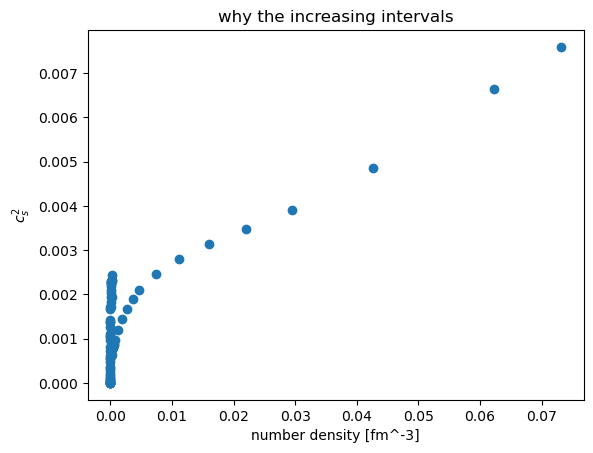

In [45]:
plt.scatter(n_crust_fromfile, cs2_crust_fromfile)
plt.xlabel('number density [fm^-3]')
plt.ylabel(r'$c_s^2$')

plt.title('why the increasing intervals')

plt.show()

# ceft

In [46]:
new_68 = np.loadtxt("../EOS/chiEFT/chiEFT_band_68_percent_credibility.txt").T

In [47]:
n, cs2_l, cs2_u = new_68

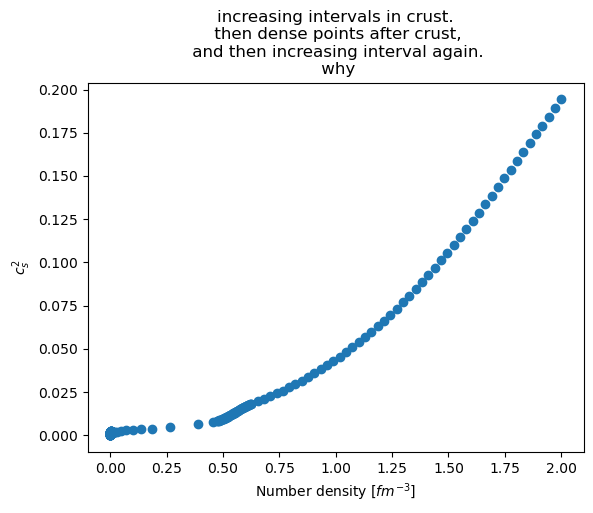

In [48]:
plt.scatter(n/ns, cs2_l)
plt.xlabel(r'Number density [$fm^{-3}$]')
plt.ylabel(r'$c_s^2$')

plt.title('increasing intervals in crust.' \
            '\n then dense points after crust,' \
            '\n and then increasing interval again.'\
            '\n why')

plt.show()

excluding the crust because the uncertainty in the crust is way to low

In [49]:
crust_end = np.where(n<=n_crust_end)[0][-1]

In [50]:
crust_end

75

In [51]:
n_crust = n[:crust_end+1]
cs2_l_crust = cs2_l[:crust_end+1]
cs2_u_crust = cs2_u[:crust_end+1]

### finding init vals for e and p to build crust

using the old crust to find suitable values for begining of new crust

In [52]:
n_crust[0]

2.72e-14

In [53]:
ceft_lower_old = np.loadtxt('../EOS/ceft/eos_ceft_lower.dat')
n_ceft_lower_old, p_ceft_lower_old, e_ceft_lower_old = ceft_lower_old.T

ceft_upper_old= np.loadtxt('../EOS/ceft/eos_ceft_upper.dat')
n_ceft_upper_old, p_ceft_upper_old, e_ceft_upper_old = ceft_upper_old.T

n_ceft_old, p_ceft_lower_old, e_ceft_lower_old = ceft_lower_old.T


n_ceft_old = n_ceft_lower_old # fm^-3

e_ceft_old = (e_ceft_lower_old+e_ceft_upper_old)/2
p_ceft_old = (p_ceft_lower_old+p_ceft_upper_old)/2

crust_end_old = np.where(n_ceft_old<=0.076)[0][-1]

n_crust_old = n_ceft_old[:crust_end_old+1]
e_crust_old = e_ceft_old[:crust_end_old+1]
p_crust_old = p_ceft_old[:crust_end_old+1]

e_interp_old = interp1d(n_crust_old, e_crust_old)
p_interp_old = interp1d(n_crust_old, p_crust_old)

e_ini = e_interp_old(n_crust[0])
p_ini = p_interp_old(n_crust[0])

In [54]:
e_ini = crust_df.iloc[0]["eps"]
n_ini = crust_df.iloc[0]["n"]
p_ini = crust_df.iloc[0]["p"]
mu_ini = 939.565 # rest mass of neutron


In [55]:
eos_l_crust = eos.EosProperties(n_crust/0.16, phi=None, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini, cs2=cs2_l_crust)
eos_u_crust = eos.EosProperties(n_crust/0.16, phi=None, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini, cs2=cs2_u_crust)

In [56]:
properties_u_crust = eos_u_crust.get_all()

properties_l_crust = eos_l_crust.get_all()

In [57]:
properties_l_crust["mu"]

array([939.565     , 939.5650869 , 939.5649718 , 939.56682054,
       939.56887987, 939.57328516, 939.58100399, 939.59594581,
       939.61958899, 939.66293216, 939.72087496, 939.74038453,
       939.81021823, 939.91382271, 940.03871848, 940.21342639,
       940.41064105, 940.48690742, 940.65917412, 940.87900241,
       940.99879469, 941.23483944, 941.50697367, 941.86376666,
       942.23907348, 942.42569466, 942.65578206, 942.92598709,
       943.1803043 , 943.46935003, 943.7188624 , 944.0720257 ,
       944.40251784, 944.57401585, 945.08060821, 945.56040543,
       946.02796299, 946.48934501, 946.93856142, 947.3819837 ,
       947.8136476 , 947.89850804, 947.98429067, 948.06950488,
       948.15305446, 948.23721998, 948.3209044 , 948.35524072,
       948.35825171, 948.3634488 , 948.34265054, 948.37599178,
       948.40726493, 948.4391557 , 948.4712136 , 948.51361678,
       948.61848892, 948.72397968, 948.82833752, 948.93260147,
       949.03618178, 949.13982719, 949.34608867, 949.86

In [58]:
properties_l_crust["pressure"]

array([1.06105661e-19, 4.88400143e-18, 9.65365763e-17, 5.66758113e-15,
       3.01041013e-14, 1.47170150e-13, 7.05862808e-13, 3.18044769e-12,
       1.41828338e-11, 5.88156726e-11, 2.33138889e-10, 3.20130866e-10,
       8.53655788e-10, 2.32597649e-09, 6.20503898e-09, 1.60842675e-08,
       4.03785077e-08, 5.39088251e-08, 9.86511898e-08, 1.86903661e-07,
       2.54461922e-07, 4.37872701e-07, 7.84267822e-07, 1.48361003e-06,
       2.71847436e-06, 3.53827527e-06, 4.78827635e-06, 6.66288168e-06,
       8.94862237e-06, 1.21990169e-05, 1.56547760e-05, 2.17893328e-05,
       2.92593281e-05, 3.37977799e-05, 5.04138517e-05, 7.15149745e-05,
       9.87468515e-05, 1.33191198e-04, 1.75948916e-04, 2.28523280e-04,
       2.92017927e-04, 3.06077602e-04, 3.20869306e-04, 3.36158718e-04,
       3.51747980e-04, 3.68069346e-04, 3.84935133e-04, 3.92041901e-04,
       3.92668288e-04, 3.93751458e-04, 3.89553238e-04, 3.96865078e-04,
       4.03969806e-04, 4.11480164e-04, 4.19334815e-04, 4.30230662e-04,
      

# smoothing new cheft

In [60]:
n_ceft = n[crust_end:]
cs2_l_ceft = cs2_l[crust_end:]
cs2_u_ceft = cs2_u[crust_end:]

In [61]:
n_test = np.linspace(n_ceft[0], n_ceft[-1], 100)

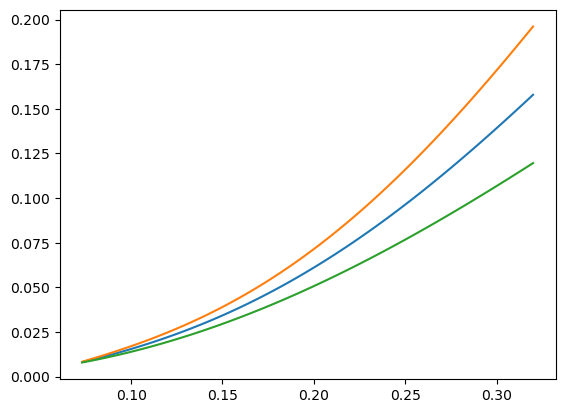

In [104]:
sig = 0.01
l = 0.5

kern = kernels.Kernel("SE", sigma=sig, l=l)
gp_l = gaussianprocess.GP(kern)

gp_l.fit(n_ceft, n_test, cs2_l_ceft, stabilise=True)

cs2_l_test = gp_l.posterior(sampling=True)

gp_l = gaussianprocess.GP(kern)
gp_l.fit(n_ceft, n_test, cs2_l_ceft, stabilise=True)
cs2_l_test = gp_l.posterior(sampling=True)

gp_u = gaussianprocess.GP(kern)
gp_u.fit(n_ceft, n_test, cs2_u_ceft, stabilise=True)
cs2_u_test = gp_u.posterior(sampling=True)

plt.plot(n_test, (cs2_u_test.flatten()+cs2_l_test.flatten())/2)
plt.plot(n_test, cs2_l_test.flatten())
plt.plot(n_test, cs2_u_test.flatten())
